In [2]:
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import json
from tqdm import tqdm

# Download necessary resources from NLTK
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dcolo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
def preprocess_text(text):
    # Remove punctuation and special characters
    # print(text)
    text = re.sub(r'[^\w\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize the text into words
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Join the tokens back into a single string
    processed_text = ' '.join(tokens)
    
    return processed_text

In [ ]:
#  Dump all artilces into one file as title category and text
# os.chdir("D:/nlp/")
# article_dump_folder = 'cleaned_articles'

# # List all JSON files in the folder
# json_files = [f for f in os.listdir(article_dump_folder) if f.endswith('.json')]

# # Extract text, title, and categories from each JSON file
# articles = []
# for json_file in json_files:
#     with open(os.path.join(article_dump_folder, json_file), 'r') as file:
#         article_data = json.load(file)
        
#         title = article_data['title']
#         text = article_data['text']
#         categories = article_data['categories']
        
#         articles.append({'title': title, 'text': text, 'categories': categories})

In [ ]:
# with open("articles_dump.json", "w", encoding="utf8") as f:
#     json.dump(articles, f, indent=2, ensure_ascii=False)

In [5]:
os.chdir("D:/nlp/")
with open("articles_dump.json", "r", encoding="utf8") as f:
    articles = json.load(f)

In [6]:
# Preprocess the text
preprocessed_texts = [preprocess_text(article['text'][0]) for article in tqdm(articles)]

100%|██████████| 538077/538077 [04:00<00:00, 2234.90it/s]


In [7]:
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(preprocessed_texts)



In [8]:
# Get the feature names (words) from the vectorizer

feature_names = vectorizer.get_feature_names_out()



In [ ]:
# # Print the preprocessed text, title, and the corresponding TF-IDF matrix
# for article, preprocessed_text, tfidf_vector in (zip(articles, preprocessed_texts, tfidf_matrix)):
#     print('Title:', article['title'])
#     print('Preprocessed Text:', preprocessed_text)
#     print('TF-IDF Vector:', tfidf_vector.toarray())
#     print('------------------------------------')

In [10]:
def calculate_jaccard_similarity(category1_articles, category2_articles):
    category1_set = set(category1_articles)
    category2_set = set(category2_articles)
    
    intersection = len(category1_set.intersection(category2_set))
    union = len(category1_set) + len(category2_set) - intersection
    
    jaccard_similarity = intersection / union
    return jaccard_similarity


In [115]:


# List of categories and their corresponding articles
categories = []
category_articles = {}
for article in tqdm(articles):
    for category in article['categories']:
        categories.extend(category.split(":")[1])






100%|██████████| 538077/538077 [00:03<00:00, 173954.63it/s]


In [116]:
for article in tqdm(articles):
    for category in (article['categories']):
        if category not in category_articles:
            category_articles[category] = []
        category_articles[category].append(article["title"])

100%|██████████| 538077/538077 [00:04<00:00, 117253.36it/s]


In [117]:
category_articles.__len__()

613087

In [118]:
category_articles_filtered = {
    category: articles for category, articles in category_articles.items() if len(articles) >= 1000}
category_articles_filtered.__len__()

categories = list(category_articles_filtered.keys())


In [119]:
categories.__len__()

57

In [122]:

# Compute category similarity incrementally using random projection and sparse matrix
num_categories = len(categories)

# Random projection for dimensionality reduction
similarity_matrix = np.zeros((num_categories, num_categories))

for i, category1 in tqdm(enumerate(categories)):
    for j, category2 in enumerate(categories):
        if i == j:
            similarity_matrix[i, j] = 1.0  # Similarity between the same category is 1.0
        elif i < j:
            category1_articles = category_articles[category1]
            category2_articles = category_articles[category2]

            jaccard_similarity = calculate_jaccard_similarity(category1_articles, category2_articles)

            similarity_matrix[i, j] = jaccard_similarity
            similarity_matrix[j, i] = jaccard_similarity

# Print the similarity matrix
print(similarity_matrix)


0it [00:00, ?it/s]


ValueError: could not convert string to float: 'Andre Agassi'

In [ ]:
# from scipy.cluster.hierarchy import linkage, dendrogram

# # Perform hierarchical clustering
# linkage_matrix = linkage(similarity_matrix, method='complete')


In [ ]:
sorted_indices = similarity_matrix.mean(axis=1).argsort()[::-1]
top_categories = [categories[idx] for idx in sorted_indices[:100]]

# Subset the similarity matrix and categories for the top ten categories
top_similarity_matrix = similarity_matrix[np.ix_(sorted_indices[:100], sorted_indices[:100])]
top_categories = [categories[idx] for idx in sorted_indices[:100]]
Z = linkage(top_similarity_matrix, method='average', metric='euclidean')



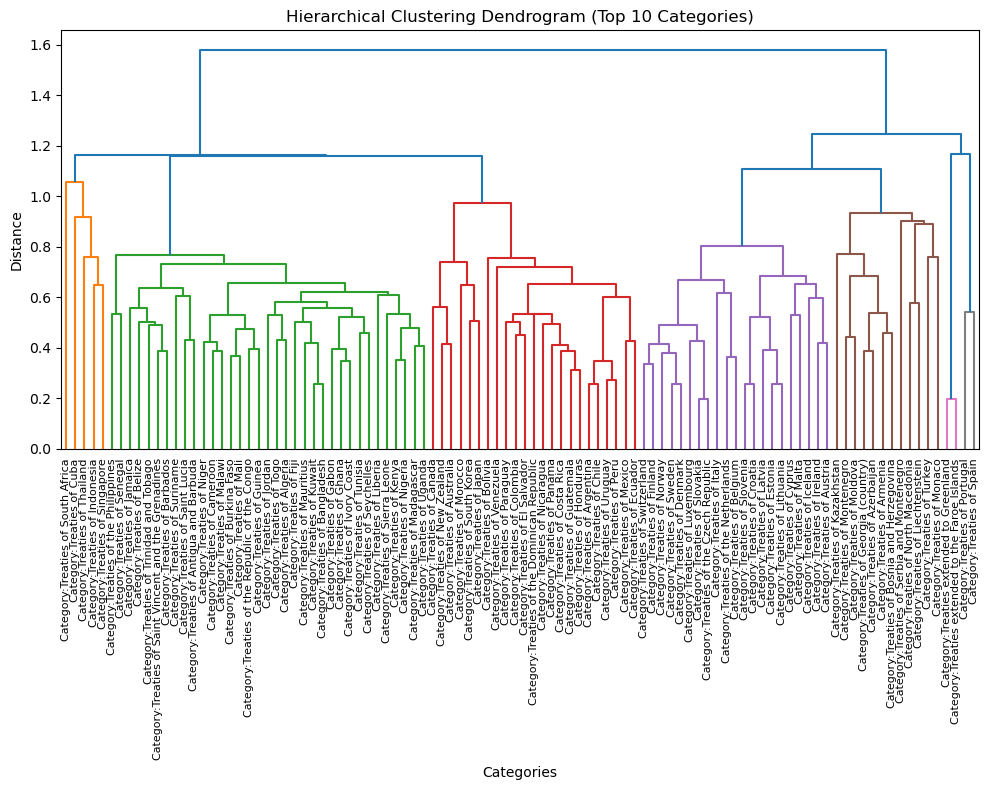

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
dendrogram(Z, labels=top_categories, orientation='top')

plt.title('Hierarchical Clustering Dendrogram (Top 10 Categories)', fontsize=12)
plt.xlabel('Categories', fontsize=10)
plt.ylabel('Distance', fontsize=10)
plt.xticks(rotation=90, fontsize=8)

# Show the plot
plt.tight_layout()
plt.show()